In [1]:
from lib import *

## Partial differential equations - wave-type equations

Scheme: 
1. Discretize the spatial dimention: $u_n=u(x_n,t)$  (for example $x_n=nh$) 

2. write a system of $N$ second order (or $2N$ first order) time differential equations:
$$\partial_{tt}u_n=D_{nm}u_m-F_n$$


* write a system of $𝑁$ second order equations:

    $$ u_n''\approx \frac{u_{n-1}-2u_n+u_{n+1}}{h^2}$$

    $$D_{n,m} = \delta_{n-1, m}- 2\delta_{n, m} +\delta_{n+1, m}  \cdot \frac{1}{dx^2}, \qquad n,m = 0,1,2,3,..., N-1$$
    

* write a system of $2 𝑁$ first order equations:

$$ \vec{v}=(u, \partial_x u)$$

$$ \partial_x \vec{v}=(\partial_x u, \partial_{xx} u)$$

$$ u'_n=\frac{u_{n+1}-u_{n-1}}{2h}$$

$$D_{n,m} = ? , \qquad n,m = 0,1,2,3,..., 2N-1$$


3. use some time-stepping method to solve the system for given initial conditions $u(x, 0), \partial_t u(x, 0)$ and boundary conditions, such as $u(0,t)=f(x)$ and $u(L,t)=g(x)$.
* Runge-Kutta method
* simplectic method

4. Important issue: stability.

For explicit methods time step must be adjusted to the highest eigenvalue of $D_{nm}$
(a saw-type function).
$\lambda \approx (dx)^{−2}$

## sine-Gordon model:

$$ \partial_{tt}u = \partial_{xx}u - \sin(u)$$

1. initial conditions:

* $u(x, 0) = 0 \qquad (position)$

* $\partial_t u(x, 0) =  \left\{\begin{array}{rcl} \omega  \qquad for \qquad x = 0 \\ 0  \qquad for \qquad x>0 \end{array} \right. \qquad (velocity)$

2. boundary conditions:

* $u(0, t) = \sin( \omega t) \qquad $

* $u(L, t) = -\sin( \omega t) \qquad $

(sth like a bunch of pendulums on a straight line, with the first and last pendulum rotating)

### Implementation:

1. spatial dimention discretization:

* $ x_n = n\cdot h \qquad n=0,1,2,3,...,N-1$

* $ u_n(t) = u(t, x_n)$



2. discretized initial conditions:

* $u_n(0) = 0 \qquad (position)$

* $\partial_t u_n(0) =  \left\{\begin{array}{rcl} \omega  \qquad for \qquad n = 0 \\ 0  \qquad for \qquad n>0 \end{array} \right. \qquad (velocity)$




3. discretized boundary conditions:

* $u_0(t) = \sin( \omega t) \qquad $

* $u_{N-1}(t) = -\sin( \omega t) \qquad $




4. write a system of $𝑁$ second order equations:

$$ u_n''\approx \frac{u_{n-1}-2u_n+u_{n+1}}{h^2}$$

$$D_{n,m} = \delta_{n-1, m}- 2\delta_{n, m} +\delta_{n+1, m}$$

$$ \partial_{tt}u_n =  \frac{u_{n-1}-2u_n+u_{n+1}}{h^2} - \sin(u_n) = D_{n,m}u_m - sin(u_n)$$

where:
$$D_{n,m} = \delta_{n-1, m}- 2\delta_{n, m} +\delta_{n+1, m}, \qquad n,m = 0,1,2,3,..., Nx$$

5. 
* $n,m = 0,1,2,3,..Nx$ - indexing of spatial coordinates
* $i,j = 0,1,2,3,..Nt$ - indexing of temporal coordinates


In [2]:
def get_D_second_order(N):
    
    '''
        𝐷𝑛,𝑚 = 𝛿𝑛−1,𝑚 − 2𝛿𝑛,𝑚 + 𝛿𝑛+1,𝑚
        No boundary conditions included
        
    '''
    D = np.diagflat( np.ones(N) * (-2))
    
    for i in range(1,N-1):
        D[i][i+1] = 1
        D[i][i-1] = 1
    
    return D

### simplectic method:
$$ \partial_t u^i = v^i $$
$$ \partial_{tt} u^i = \partial_t v^i = G(u^i)$$

multistep:
$$ u^{i+1/2} = u^i + \frac12 v^i dt = k^i $$
$$ v^{i+1} = v^i + G\left(u_{i+1/2}\right) dt $$
$$ u^{i+1} = u^{i+1/2}+\frac12 v^i dt $$

In our case this is:

$$ G(u^i) =  G(u^i_n) = D_{n,m}u_m - \sin(u_n) $$

$$ u^{i+1/2}_n = u^i_n + \frac12 v^i_n \cdot dt = k^i_m $$

$$ v^{i+1}_n = v^i_n + G\left(u^{i+1/2}_n\right) \cdot dt $$

$$ u^{i+1}_n = u^{i+1/2}_n +\frac12 v^i_n \cdot dt $$

In [3]:
Nx= 100   ##(50, 40000)
Nt = 100000

T = 5
L = 2

ω1 = 2
ω2 = -2

xx = np.linspace(0, L, Nx+1)
tt = np.linspace(0, T, Nt+1)

x,t = np.meshgrid(xx,tt)

dx = xx[1] - xx[0]
dt = tt[1] - tt[0]
print("dx = {:}\t dt = {:}\t dt/dx^2 = {:}".format(dx, dt, (1/dx**2 * dt)))

D = get_D_second_order(Nx+1)

dx = 0.02	 dt = 5e-05	 dt/dx^2 = 0.125


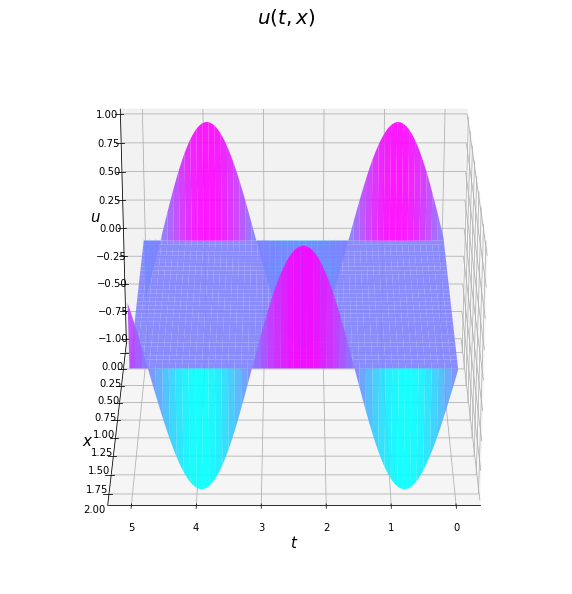

In [4]:
u = np.zeros((Nt+1,Nx+1))  ## position
v = np.zeros((Nt+1,Nx+1))  ## velocity, v = du/dt 

# set initial conditions at t=0 for position u(t,x)
u[0,:] = 0

# set initial conditions at t=0 for velocity u'(t,x)
v[0, 1:-1] = 0
v[0,0] = ω1 
v[0,-1] = ω2 

## set boundary conditions:
u[:,0] = np.sin(ω1 * tt)   
u[:,-1] = np.sin(ω2 * tt) 

plot_3D(t,x,u, elev=25., azim=90)

### simplectic method:
$$ \partial_t u^i = v^i $$
$$ \partial_{tt} u^i = \partial_t v^i = G(u^i)$$

multistep:
$$ u^{i+1/2} = u^i + \frac12 v^i dt = k^i $$
$$ v^{i+1} = v^i + G\left(u_{i+1/2}\right) dt $$
$$ u^{i+1} = u^{i+1/2}+\frac12 v^i dt $$

In our case this is:

$$ G(u^i) =  G(u^i_n) = D_{n,m}u_m - \sin(u_n) $$

$$ u^{i+1/2}_n = u^i_n + \frac12 v^i_n \cdot dt = k^i_m $$

$$ v^{i+1}_n = v^i_n + G\left(u^{i+1/2}_n\right) \cdot dt $$

$$ u^{i+1}_n = u^{i+1/2}_n +\frac12 v^i_n \cdot dt $$

In [5]:
def v1(Nt, Nx, u, v,t,x, D, azim): 
    
    for i in range(0,Nt):
        tmp = np.empty(Nx+1)  
        tmp[:] = u[i, :] + 0.5 * v[i, :] * dt    
        v[i+1,:] = v[i, :]  - np.sin(tmp)* dt  
        v[i+1,:] += dt/(dx*dx) * np.matmul(D, tmp) 
        u[i+1,:] = tmp + 0.5 * v[i, :]* dt     
        ## re-set boundary conditions:
        u[i+1:,0] = np.sin(ω1 * (i+1)*dt)   
        u[i+1:,-1] = np.sin(ω2 * (i+1)*dt)   
    
    plot_3D(t,x,u, elev=45., azim=azim)


def v2(Nt, Nx, u, v,t,x, azim):  
    
    for i in range(0,Nt):     
        tmp = np.zeros(Nx+1)          
        tmp[:] = u[i,:] + 0.5 * v[i, :] * dt     
        v[i+1,:] = v[i, :] - np.sin(tmp)* dt 
        v[i+1, 1:-1] += dt/(dx*dx) * (tmp[:-2] - 2*tmp[1:-1] + tmp[2:])      
        u[i+1,1:-1] = (tmp + 0.5 * v[i, :]* dt)[1:-1]
    
    plot_3D(t,x,u, elev=45., azim=azim)
           

def v3(Nt, Nx, u, v,t,x, azim):
     
    for i in range(0,Nt):
        tmp = np.zeros(Nx+1)        
        tmp[:] = u[i,:] + 0.5 * v[i, :] * dt    
        v[i+1,:] = v[i, :]  - np.sin(tmp)* dt      
        v[i+1, 1:-1] += dt/(dx*dx) * np.diff(tmp[:], 2)   
        u[i+1,1:-1] = (tmp + 0.5 * v[i, :]* dt)[1:-1]
    plot_3D(t,x,u, elev=45., azim=azim)
    

463 ns ± 43.3 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


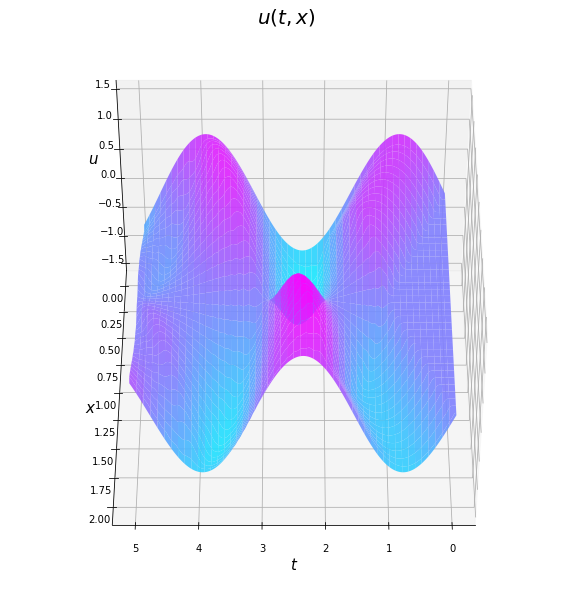

In [6]:
%timeit sum(range(10))
v1(Nt, Nx, u, v,t,x, D, azim=90)

397 ns ± 13.3 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


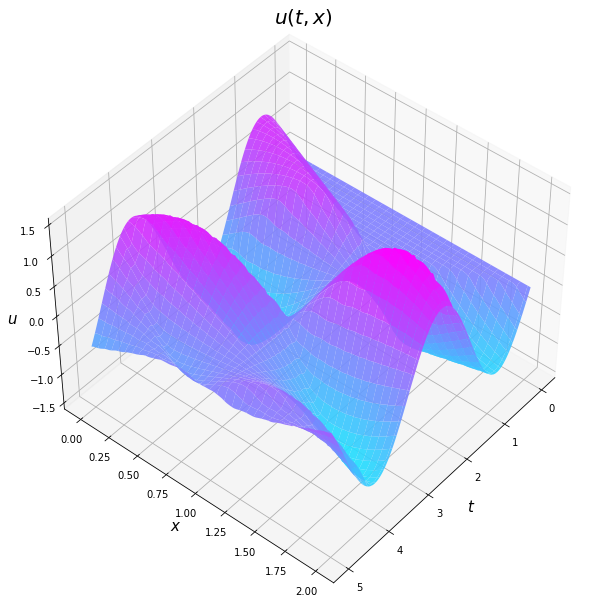

In [7]:
%timeit sum(range(10))
v2(Nt, Nx, u, v,t,x, azim=40)

403 ns ± 8.09 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


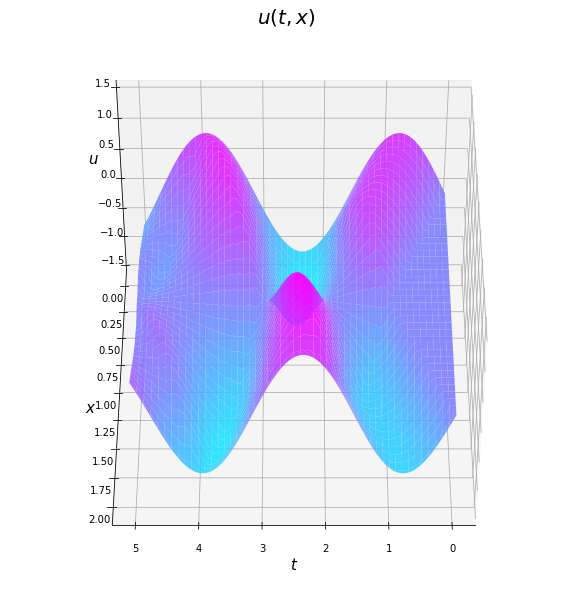

In [8]:
%timeit sum(range(10))
v3(Nt, Nx, u, v,t,x, azim=90)

### Runge–Kutta–Nyström Methods:

for $$y'' = f(x,y,y')$$ initial value problems $y(x_0) = y_0$, $y'(x_0) = y'_0$  we may use Runge-Kutta-Nyström method:

$$y_{n+1} = y_n + hy'_n + h^2 \sum _{i=0}^m \bar{b}_i k'_i$$

$$y'_{n+1} = y'_n + h \sum _{i=0}^m b_i k'_i$$


$$ k'_i = f(x_n + c_i h, y_n + c_i h y'_n + h^2 \sum _{j=1}^m \bar{a}_{ij} k'_j)$$

$m$  = number of stages


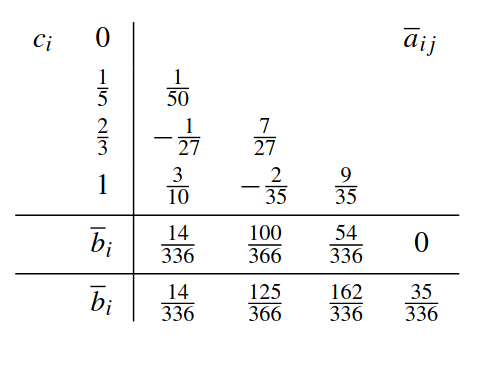